## Basic Settings

In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
doc_path = "Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/"
working_path = "C:/Users/Jesper/Google Drive/Uni docs/Statistik/Machine Learning/project/"
#working_path=""

## Loading the data
* Metainformatioon is provided in a seperate .csv file. The target Variable is "guten_genre"
* The documents are stored in a folder. They seem to be quite big when loaded in an sklearn dataset, so maybe we can not work with all the books stored in memory. 
* Alternatively we will have to pass filenames to some feature extraction method that will than return the extracted features.

In [3]:
meta = pd.read_csv(working_path+"Gutenberg_English_Fiction_1k/master996.csv", sep=";",
           header=0, encoding='latin1')

In [4]:
meta

,Book_Name,book_id,guten_genre,Author_Name
0,The Mystery of the Boule Cabinet: A Detective ...,pg10067.epub,Detective and Mystery,Stevenson| Burton Egbert
1,The Pupil,pg1032.epub,Literary,James| Henry
2,At Love's Cost,pg10379.epub,Literary,Garvice| Charles
3,The Heart of the Range,pg10473.epub,Western Stories,White| William Patterson
4,The Worshipper of the Image,pg10812.epub,Literary,Gallienne| Richard Le
...,...,...,...,...
991,David Copperfield,pg766DickensDavidCopfld.epub,Literary,Dickens| Charles
992,Hard Times,pg786DickensHardTimes.epub,Literary,Dickens| Charles
993,Memoirs of Shelock Holmes,pg834DoyleMemoirsSherlk.epub,Detective and Mystery,Connan| Doyle
994,The Mysterious Affair at Styles,pg863Agatha1.epub,Detective and Mystery,Christie| Agatha


In [5]:
#Extract target Variable and filenames
target = meta["guten_genre"]
book_id = meta["book_id"]
filenames = [working_path+doc_path+id.split(".")[0]+"-content.html" for id in book_id]
#There are two empty Documents (465, 622). those will be excluded.
filenames.pop(465)
filenames.pop(622)
target.pop(465)
target.pop(622)
book_id.pop(465)
book_id.pop(622)
len(filenames)

994

In [6]:
target.value_counts()
#The dataset is highly unbalanced, a classifier that only predicts
#"Literay" will get 79% Accuracy!

Literary                       792
Detective and Mystery          111
Sea and Adventure               36
Western Stories                 18
Love and Romance                18
Humorous and Wit and Satire      6
Ghost and Horror                 6
Christmas Stories                5
Allegories                       2
Name: guten_genre, dtype: int64

In [7]:
#Making train and test-dataset
from sklearn.model_selection import train_test_split
filenames_train, filenames_test, y_train, y_test = train_test_split(
                filenames, target, test_size=0.33)

In [8]:
#This will only work if "load_content=False". But its probably not usefull, 
#because it contains the files that are unlabelled.
#from sklearn import datasets
#data = datasets.load_files("Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k",
#                   shuffle=False, load_content=False)

## Train simple Bow model
* We will pass input=filename to the vectorizer. This will go through the files individually.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = CountVectorizer(input = "filename")
train_vectors = vectorizer.fit_transform(filenames_train)
test_vectors = vectorizer.transform(filenames_test)

In [10]:
vectorizer.vocabulary_

{'well': 132704,
 'of': 84021,
 'all': 4521,
 'the': 119772,
 'hare': 55253,
 'brained': 15893,
 'proposals': 95124,
 'ever': 42230,
 'listened': 71026,
 'to': 121300,
 'this': 120135,
 'takes': 118082,
 'bun': 17580,
 'and': 5566,
 'felix': 44641,
 'muller': 80105,
 'adjusted': 3012,
 'his': 57660,
 'pince': 91075,
 'nez': 82104,
 'lay': 69244,
 'back': 9562,
 'in': 61175,
 'chair': 21255,
 'laughed': 69034,
 'softly': 111480,
 'but': 18016,
 'why': 133614,
 'asked': 7920,
 'companion': 25540,
 'seriously': 107396,
 'singular': 109621,
 'admit': 3068,
 'it': 64285,
 'may': 75516,
 'be': 11194,
 'startling': 114103,
 'if': 60199,
 'you': 135937,
 'like': 70584,
 'do': 35847,
 'not': 82968,
 'see': 106703,
 'that': 119739,
 'there': 119918,
 'is': 64132,
 'anything': 6305,
 'laugh': 69031,
 'at': 8333,
 'don': 36267,
 'lawyer': 69229,
 'face': 43392,
 'became': 11447,
 'suddenly': 116123,
 'grave': 52723,
 'realise': 98255,
 'what': 133038,
 'your': 135959,
 'proposal': 95123,
 'implies

In [11]:
#Importing model for classification (here Naive Bayes)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_vectors, y_train)
#Measuring accuracy on the training set
np.mean(nb.predict(train_vectors) == y_train)

0.9744360902255639

In [12]:
np.mean(nb.predict(test_vectors) == y_test)
#~10% Validation error! Only ~7% Above baseline this can be better!

0.8601823708206687

## How might we extract features?
* I want to illustrate how we could extract some features by only using the filenames. I will use the simplest possible feature: number of characters, which should indicate plot complexity to some extend.
* Also I think one possible workflow could be to split up the feature extraction by some theretical consideration (semantic vs. syntactic e.g.).

In [13]:
#Extract features takes a method (extractor) and filenames
#as argument and returns one feature. We could wrap this up by concatenating
#and just hand over a list of extracors to get our dataset ready.
def extract_feature(extractor, filenames):
    feature = []
    for filename in filenames:
        file = open(filename, "r", encoding="utf8")
        text = file.read()
        feature.append(extractor(text)) #type: String
        file.close()
    return(feature)

In [14]:
def extract_features(extractor_list, filenames):
    feature = [[]]
    for filename in filenames:
        file = open(filename, "r", encoding="utf8")
        text = file.read()
        text = word_tokenize(text)
        feature.append([extractor(text) for extractor in extractor_list]) #type: word_tokenizer
        file.close()
    return(feature)

## Extractors

### Word, Punctuation and Sentence Statistics

In [101]:
#Now we use NLTK for the extraction of some simple feature
import nltk
from  nltk.sentiment.util import mark_negation
from nltk.tokenize import word_tokenize
from nltk import wordnet as wn
from nltk.corpus import sentiwordnet as swn
#nltk.download()
import sklearn as sk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
import codecs

In [ ]:
def num_words(name_list):     
        word_num = []
        for q in range(len(name_list)):
            file = codecs.open(name_list[q], "r", "utf-8").read()
            words = len(file.split())
            word_num.append(words)
        return word_num

In [ ]:
def num_lines(name_list):
        line_num = []
        for q in range(len(name_list)):
            file = codecs.open(name_list[q], "r", "utf-8").read()
            lines = file.count('<p>')
            line_num.append(lines)
        return line_num

In [ ]:
def num_punctuation(name_list):
        punct_num = []
        for q in range(len(name_list)):
            file = codecs.open(name_list[q], "r", "utf-8").read()
            words = len(file.split())
            
            punct_1 = file.count(':') 
            punct_2 = file.count(',')
            punct_3 = file.count('"')
            punct_4 = file.count('/')
            punct_5 = file.count('(')
            punct_7 = file.count('[')
            punct_9 = file.count('{')
            punct_11 = file.count(';')
            punct_12 = file.count('&')
            punct_13 = file.count('-')
            punct = punct_1+punct_2+punct_3+punct_4+punct_5+punct_7+punct_9+punct_11+punct_12+punct_13
            
            # if words > 0:      
            rel_punct = punct/words
            punct_num.append(rel_punct)
                
        return punct_num    

In [ ]:
def num_sent(name_list):

        sent_num = []
        for q in range(len(name_list)):
            file = codecs.open(name_list[q], "r", "utf-8").read()
            words = len(file.split())
            
            sent_1 = file.count('.') 
            sent_2 = file.count('!')
            sent_3 = file.count('?')
     
            sent = sent_1+sent_2+sent_3
        
            # if words > 0:
            rel_sent = words/sent
            sent_num.append(rel_sent)
            
        return sent_num 

### Named Entity Recognition

In [94]:
import os
import json
import sklearn as sk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
os.environ['JAVAHOME'] = "/usr/java/jre1.8.0_251/bin/java"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jesper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
BASE_PATH = "/home/richhiey/Desktop/workspace/academics/courses/semester_4/Advanced Topics in Machine Learning/course_project"
CORPUS_PATH = os.path.join(BASE_PATH, "Gutenberg_English_Fiction_1k")
DATA_PATH = os.path.join(CORPUS_PATH, "Gutenberg_19th_century_English_Fiction")

In [ ]:
file = filenames[100]
content = open(file, 'r').read()
sentences = content.split('<p>')
sentences = list(map(lambda x:x.rstrip(), sentences))
     
classifier_path = os.path.join(BASE_PATH, "stanford-ner-4.0.0", "classifiers", "english.all.3class.distsim.crf.ser.gz")
ner_jar_path = os.path.join(BASE_PATH, "stanford-ner-4.0.0", "stanford-ner.jar")
ner_tagger = StanfordNERTagger(classifier_path, ner_jar_path, encoding="utf-8")

def detect_dialog(sentence):
    num_quotes = sentence.count('"')
    return num_quotes/2

print('Example of Named Entity Recognition using Stanford NER through nltk')
temp_sentence_list = sentences[300:320]

people = set([])
places = set([])
organizations = set([])

for sentence in temp_sentence_list:
    print('---------------------------------------------------------------------------------------')
    print(sentence)
    
    is_dialog = detect_dialog(sentence)
    print('---- How many dialogs? ----')
    print(is_dialog)
    
    named_entities = []
    classified_text = ner_tagger.tag(word_tokenize(sentence))
    
    for word in classified_text:
        if word[1] == "PERSON":
            people.add(word[0])
            named_entities.append(word[0])
        if word[1] == "LOCATION":
            places.add(word[0])
            named_entities.append(word[0])
        if word[1] == "ORGANIZATION":
            organizations.add(word[0])
            named_entities.append(word[0])
    
    print('---- Named Entities ? ----')
    print(named_entities)
    print('---------------------------------------------------------------------------------------')

print('People in the texts')
('---------------------------------------------------------------------------------------')
print(people)
print('Places in the texts')
('---------------------------------------------------------------------------------------')
print(places)
print('Organizations in the texts')
('---------------------------------------------------------------------------------------')
print(organizations)
('---------------------------------------------------------------------------------------')

In [ ]:
files_dict = {}
for file_name in filenames:
    people = set([])
    places = set([])
    organizations = set([])
    content = open(file_name, 'r').read()
    classified_text = ner_tagger.tag(word_tokenize(content))
    
    for word in classified_text:
        if word[1] == "PERSON":
            people.add(word[0])
        if word[1] == "LOCATION":
            places.add(word[0])
        if word[1] == "ORGANIZATION":
            organizations.add(word[0])    
    
    total_dialogs = 0
    total_sentences_with_dialogs = 0
    sentences = content.split('<p>')
    sentences = list(map(lambda x:x.rstrip(), sentences))
    
    for sentence in sentences:
        num_dialogs = detect_dialog(sentence)
        total_dialogs += num_dialogs
        if num_dialogs > 0:
            total_sentences_with_dialogs += 1

    files_dict[file_name] = {
        'n_sentences': len(sentences),
        'n_dialogs': total_dialogs,
        'n_sentences_with_dialogs': total_sentences_with_dialogs,
        'places': list(places),
        'n_places': len(places),
        'people': list(people),
        'n_people': len(people),
        'organizations': list(organizations),
        'n_organizations': len(organizations),
    }
    
print(files_dict)

#print('Writing to JSON ..')
#json_object = json.dumps(files_dict, indent = 4) 
#with open("ner_features.json", "w") as outfile: 
#    outfile.write(json_object)
#print('Done!')

### Sentiment Analysis
Fiction is very sentimental at times. So Sentiment might be a good Feature to extract in order to learn the Genre. For example Love and Romance storys are expected to have strong sentiments, as they normally include a lot of positive and negative feelings. Generally positive, negative and neutral Sentiment can be extracted, to give a more complex view on the feelings and opinions occuring in the Story. In order to extract Sentiment we will make some simplyfying assumtpions. Firstly we will assume, that sentiment can be measured on the word Level. So no structual information of any longer Sequences of Text will be used, apart from negations that will be assingend to all words in a sentence, following some negationing adjective. To achieve this nltk's toolkit for Sentiment analysis will be used[1]. In order to assign Sentiments to each word the sentiwordnet database will be used[2]. Here it will be assumed, that the sentiment of the most common usage of a word is sufficiant to derive overall sentiment. In order to keep it simple sentiment will only be derived from all nouns, verbs and adjectives and crunched in one number per dimension (positive, negative, neutral) by averaging over all sentences in the document. This might be very restrictive because some word-types might even out the sentiment of other word types, but it should still somehow measure the concept. Also the Average is only computed using half of the sentences of each Document for efficiency reasons. 


[1] nltk.sentiment.util.mark_negation(), version...
[2] sentiwordnet

In [98]:
example = open(filenames[0]).read()

In [ ]:
from nltk.tokenize import word_tokenize
#sentences = example.split("\n")
#sentences = "".join(sentences)
sentences = example.split("<p>")
sentences = ". ".join(sentences)
sentences = nltk.sent_tokenize(sentences)
token_sentences = [word_tokenize(sentence) for sentence in sentences]
#Before all punctuation is gone: apply negations
token_sentences = [mark_negation(sentence) for sentence in token_sentences]
#Filter out punctuation
token_sentences = [[word for word in sentence if word.isalpha() or "_NEG" in word] for sentence in token_sentences]
#tok_example = word_tokenize(sentences)
token_sentences = list(filter(None, token_sentences))

In [24]:
print(swn.senti_synset('sadly.r.01'))

<sadly.r.01: PosScore=0.0 NegScore=0.625>


In [5]:
print(swn.senti_synset('passion.n.01'))

<passion.n.01: PosScore=0.5 NegScore=0.0>


In [25]:
def get_senti_scores(tuple):
    typ = tuple[1]
    word = tuple[0]
    Negation = len(word.split("_"))
    word = word.split("_")[0]
    type_dict = {
        "VBB": "v",
        "VBG": "v",
        "VBN": "v",
        "VBP": "v",
        "VBZ": "v",
        "NN": "n",
        "NNS": "n",
        "NNP": "n",
        "NNPS": "n",
        "RB": "r",
        "RBR": "r",
        "RBS": "r",
        "JJ": "a",
        "JJR": "a",
        "JJS": "a",
    }
    typ = type_dict.get(typ)
    senti_res = [".",".","."]
    if(typ!=None):
        call_string = "{}.{}.01".format(word,typ)
        try:
            senti = swn.senti_synset(call_string)
            if(Negation==1):
                senti_res[0] = senti.pos_score()
                senti_res[1] = senti.neg_score()
                senti_res[2] = senti.obj_score()
            else:
                senti_res[1] = senti.pos_score()
                senti_res[0] = senti.neg_score()
                senti_res[2] = senti.obj_score()
        except:
            senti_res = [np.nan,np.nan,np.nan]
    return(senti_res)

In [26]:
print(get_senti_scores(("bad_NEG", "JJR")))

[0.625, 0.0, 0.375]


In [27]:
def get_sentence_sentiment(sentence, mean = True):
    sentence = nltk.pos_tag(sentence)
    sentiments = [get_senti_scores(word) for word in sentence]
    if(mean==True):
        sentiments = [sentiment for sentiment in sentiments if sentiment != [".",".","."]]
        mean = np.nanmean(np.asarray(sentiments), axis=0)
        #check wether type is none
        if(type(mean)==np.float64):
            return([np.nan,np.nan,np.nan])
        else:
            return(mean)#.tolist()
    return(sentiments)

In [28]:
sents = [get_sentence_sentiment(sentence) for sentence in token_sentences]

<ipython-input-27-0ef5e7fad8b8>:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.asarray(sentiments), axis=0)


In [29]:
np.nanmean(np.asarray(sents), axis = 0)

array([0.06955574, 0.0711447 , 0.85929956])

In [30]:
import random
def sentiment_extractor(document, keep=0.1):
    #Extract Sentences
    sentences = document.split("<p>")
    if len(sentences) <= 2:
        return([np.nan, np.nan, np.nan])
    sentences = ". ".join(sentences)
    sentences = nltk.sent_tokenize(sentences)
    sentences = random.sample(sentences, k = int(len(sentences)*1))
    token_sentences = [word_tokenize(sentence) for sentence in sentences]
    #Before all punctuation is gone: apply negations
    token_sentences = [mark_negation(sentence) for sentence in token_sentences]
    #Filter out punctuation
    token_sentences = [[word for word in sentence if word.isalpha() or "_NEG" in word] for sentence in token_sentences]
    #Remove Empty Senetnces
    token_sentences = list(filter(None, token_sentences))
    #Get Sentiments for all Sentences
    sents = [get_sentence_sentiment(sentence) for sentence in token_sentences]
    sents = np.asarray([sent for sent in sents])
    return(np.nanmean(sents, axis=0).tolist())

In [31]:
#This is just an emtpy document (465, 622)
sentiment_extractor(open(filenames[1]).read())

<ipython-input-27-0ef5e7fad8b8>:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.asarray(sentiments), axis=0)


[0.07871065884822846, 0.07053645598115019, 0.8507528851706215]

In [32]:
sentiment_features = extract_feature(sentiment_extractor, filenames)

<ipython-input-27-0ef5e7fad8b8>:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.asarray(sentiments), axis=0)


### Pronouns
Nowadays a lot of the Gender differences in interests are vanishing, but still there is some predictive power of gender for personal interests[1]. In the 19th Century this was propably also the case. Presumably correlation of gender and interests was even stronger, as Gender equality was not achieved to a high extend. So extracting Gender orientation of texts might be a valid approach to classify genre in our dataset. We assume that gender orientation can be measured by comparing the usage of gender-specific Pronouns. We will therefor simply count all the male and female-specific pronouns and derive two Features from that by dividing with the total Number of Words per Document. Dividing is necessary to avoid high correlation with Number of Words. The Extraction of These features is achieved by using simple nltk methods and pure Python. 


[source]

In [33]:
male_pronouns = ["he", "him", "his", "himself"]
female_pronouns = ["she", "her", "hers", "herself"]

In [34]:
from collections import Counter
def wordlist_frequency_extractor(document, wordlist, relative = False):
    document = document.split("<p>")
    document = ". ".join(document)
    words = word_tokenize(document)
    words = [word.lower() for word in words]
    words = [word for word in words if word.isalpha()]
    count_dict = Counter(words)
    freqs = [count_dict.get(key) for key in wordlist if key in words]
    if(relative == True):
        return(sum(freqs)/len(words))
    return(sum(freqs))

In [35]:
def female_pronoun_extractor(document):
    return(wordlist_frequency_extractor(document, female_pronouns))

In [36]:
def male_pronoun_extractor(document):
    return(wordlist_frequency_extractor(document, male_pronouns))

In [37]:
female_pronoun_freq = extract_feature(female_pronoun_extractor, filenames)

(array([399., 276., 159.,  77.,  45.,  21.,  13.,   3.,   0.,   1.]),
 array([    0. ,  1018.8,  2037.6,  3056.4,  4075.2,  5094. ,  6112.8,
         7131.6,  8150.4,  9169.2, 10188. ]),
 <a list of 10 Patch objects>)

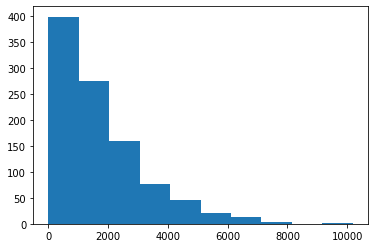

In [38]:
plt.hist(female_pronoun_freq)

In [39]:
male_pronoun_freq = extract_feature(male_pronoun_extractor, filenames)

In [ ]:
sentiment_features = np.asarray(sentiment_features)
female_pronoun_freq = np.asarray(female_pronoun_freq)
male_pronoun_freq = np.asarray(male_pronoun_freq)
word_count = np.asarray(word_count)

data_ndarray = np.stack((np.asarray(filenames), female_pronoun_freq, male_pronoun_freq, word_count), axis = 1)
data_ndarray = np.concatenate((sentiment_features, data_ndarray), axis=1)

features = pd.DataFrame(data_ndarray, columns=["filenames", "Positive Sentiment", "Negative Sentiment", "Objective Sentiment",
                                      "Female Orientation", "Male Orientation", "Number of words"])

## Exploratory Analysis

### Dataset merging

In [236]:
project_path = "C:/Users/Jesper/Documents/GitHub/ATiML-Project/"
sentiment_pronouns = pd.read_csv(project_path+"/features/features_sentiment_pronouns.csv")
word_sent_punct = pd.read_csv(project_path+"features/features_mark.csv")
entities = pd.read_csv(project_path+"features/ner_features.csv")

In [240]:
sentiment_pronouns = sentiment_pronouns.rename(columns={"filenames": "Filename"})

In [238]:
#features = pd.read_csv("C:/Users/Jesper/Documents/GitHub/ATiML-Project/notebooks/features_sentiment_pronouns.csv")
features = pd.merge(left=sentiment_pronouns, right=word_sent_punct, on="Filename")
features = pd.merge(left = features, right = entities, on="Filename")

KeyError: 'Filename'

In [239]:
sentiment_pronouns

,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Number of words
0,0.069583,0.071145,0.859272,355.0,2719.0,93196.0
1,0.078844,0.073378,0.847779,206.0,893.0,21738.0
2,0.079451,0.083087,0.837462,4673.0,5753.0,194286.0
3,0.057817,0.066159,0.876024,761.0,3572.0,125694.0
4,0.086624,0.091678,0.821698,473.0,547.0,22676.0
...,...,...,...,...,...,...
989,0.079953,0.079557,0.840490,6750.0,8450.0,452649.0
990,0.074366,0.078430,0.847204,2101.0,3250.0,132802.0
991,0.070811,0.071905,0.857284,490.0,2866.0,110242.0
992,0.080267,0.090601,0.829131,1015.0,1476.0,80224.0


In [241]:
#features.to_csv(project_path+"/features/all_features_raw.csv", index=False)
import os
features = pd.read_csv("C:\\Users\\Jesper\\Documents\\GitHub\\ATiML-Project\\features\\all_features_raw.csv")

In [17]:
os.getcwd()

'C:\\Users\\Jesper\\Documents\\GitHub\\ATiML-Project\\notebooks'

In [242]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#data = imp.fit_transform(data)
features = pd.DataFrame(imp.fit_transform(features), columns=["Positive Sentiment", "Negative Sentiment", "Objective Sentiment",
                                      "Female Orientation", "Male Orientation", "Number of words"])

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'pg10067.epub'

In [120]:
#features["Female Orientation"] = features["Female Orientation"]/features["Number of words"]
#features["Male Orientation"] = features["Male Orientation"]/features["Number of words"]

In [243]:
features["filenames"] = np.asarray(book_id)
#features = features.drop("Number of words", axis=1)
features

,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Filename,Number of Words,Number of Paragraphs,Relative Punctuation,Average Words per Sentence,Unnamed: 0,Number of Sentences,Number of Dialogs,Number of Sentences with Dialogs,Number of Named People,Number of Named Places,Number of Named Organizations,filenames
0,0.069583,0.071145,0.859272,355.0,2719.0,pg10067.epub,68757,2282,0.175386,12.858986,0,2283,2476.5,1649,114,71,28,pg10067.epub
1,0.078844,0.073378,0.847779,206.0,893.0,pg1032.epub,17776,267,0.119768,17.444553,1,268,337.0,251,21,25,8,pg1032.epub
2,0.079451,0.083087,0.837462,4673.0,5753.0,pg10379.epub,151734,3509,0.152899,16.287462,2,3510,3265.0,2087,145,115,44,pg10379.epub
3,0.057817,0.066159,0.876024,761.0,3572.0,pg10473.epub,89228,3331,0.162158,9.886759,3,3332,3644.5,2619,173,59,37,pg10473.epub
4,0.086624,0.091678,0.821698,473.0,547.0,pg10812.epub,17883,471,0.139518,16.760075,4,472,341.0,264,14,13,7,pg10812.epub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0.079953,0.079557,0.840490,6750.0,8450.0,pg766DickensDavidCopfld.epub,358420,7080,0.125389,15.768588,991,7081,203.5,122,274,187,121,pg766DickensDavidCopfld.epub
990,0.074366,0.078430,0.847204,2101.0,3250.0,pg786DickensHardTimes.epub,103930,2255,0.121745,14.693906,992,2256,27.0,16,111,55,64,pg786DickensHardTimes.epub
991,0.070811,0.071905,0.857284,490.0,2866.0,pg834DoyleMemoirsSherlk.epub,87323,2055,0.124286,15.178689,993,2056,1913.0,1820,184,142,77,pg834DoyleMemoirsSherlk.epub
992,0.080267,0.090601,0.829131,1015.0,1476.0,pg863Agatha1.epub,57390,2532,0.170169,9.825372,994,2533,2211.5,1818,80,36,24,pg863Agatha1.epub


In [199]:
#features.to_csv("C:/Users/Jesper/Documents/GitHub/ATiML-Project/features/features_sentiment_pronouns.csv", index=False)

In [247]:
features.groupby(target).mean()

,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Number of Words,Number of Paragraphs,Relative Punctuation,Average Words per Sentence,Unnamed: 0,Number of Sentences,Number of Dialogs,Number of Sentences with Dialogs,Number of Named People,Number of Named Places,Number of Named Organizations
guten_genre,,,,,,,,,,,,,,,,
Allegories,0.078056,0.095150,0.826794,0.025581,0.034663,44016.500000,1135.500000,0.121484,16.950509,278.000000,1136.500000,263.250000,192.000000,18.500000,7.500000,7.000000
Christmas Stories,0.076540,0.086590,0.836870,0.019328,0.028104,74985.600000,1574.400000,0.142678,18.011609,684.800000,1575.400000,1336.200000,1022.400000,163.400000,98.000000,43.600000
Detective and Mystery,0.071821,0.080023,0.848157,0.018209,0.034145,72596.681818,1610.763636,0.140154,16.029446,562.836364,1611.763636,1442.931818,1015.927273,106.990909,68.236364,32.827273
Ghost and Horror,0.076944,0.078691,0.844365,0.020233,0.037244,50986.333333,1471.500000,0.145605,15.316438,567.833333,1472.500000,1352.916667,1015.166667,110.333333,64.166667,45.333333
Humorous and Wit and Satire,0.076267,0.081821,0.841913,0.017725,0.034297,56478.833333,1306.666667,0.123283,17.139571,697.000000,1307.666667,984.833333,732.000000,76.166667,57.666667,26.666667
Literary,0.074870,0.081916,0.843215,0.021799,0.033057,79344.270544,1804.217446,0.139125,16.449652,481.254109,1805.217446,1554.661188,1135.690265,136.487990,82.463970,40.166877
Love and Romance,0.077564,0.083945,0.838491,0.025858,0.032113,66598.277778,1623.055556,0.138614,15.291087,473.444444,1624.055556,1510.500000,1004.277778,112.833333,64.944444,31.722222
Sea and Adventure,0.073621,0.081232,0.845147,0.018578,0.030296,86402.333333,1739.138889,0.142405,18.034678,581.666667,1740.138889,1531.763889,1070.138889,129.916667,84.194444,36.000000
Western Stories,0.075302,0.078737,0.845961,0.016430,0.032659,74612.555556,1918.111111,0.141400,15.769026,539.888889,1919.111111,1825.277778,1292.500000,137.166667,74.722222,33.888889


In [248]:
features.groupby(target).mean().round(3).to_csv("mean_diffs.csv")

In [146]:
#Make Histogramms 
def hist_plot(dataset, variables, rows=2, cols=2, size=10, transform=lambda *args: args):
    fig = plt.figure(figsize=(size, size))
    fig.tight_layout(pad=3.0)
    counter=0
    for row in range(rows):
        for col in range(cols):
            if(counter < len(variables)):
                fig.add_subplot(rows, cols, counter+1)
                plt.title("Histogram of {}".format(variables[counter]), fontsize=17)
                #plt.axis("off")
                plt.hist(transform(dataset[variables[counter]]))
                #plt.xticks(rotation=90)
            counter+=1

In [153]:
import numpy as np 
import pylab 
import scipy.stats as stats

def qq_plot(dataset, variables, rows=2, cols=2, size=10, transform=lambda *args: args):
    fig = plt.figure(figsize=(size, size))
    fig.tight_layout(pad=3.0)
    counter=0    
    for row in range(rows):
        for col in range(cols):
            if(counter < len(variables)):
                pylab.subplot(rows, cols, counter+1)
                plt.title("Histogram of {}".format(variables[counter]))
                #plt.axis("off")
                stats.probplot(dataset[variables[counter]], dist="norm", plot=pylab)
                pylab.show()
                #plt.xticks(rotation=90)
            counter+=1

### Word, Punctuation and Sentence Statistics
Fill in Explanatory Analysis

### Named Entities

In [ ]:
with open("../features/ner_features.json") as json_file:
    features = json.load(json_file)
            
sentence_stats = []
dialog_stats = []
sentence_with_dialog_stats = []
people_stats = []
places_stats = []
orgs_stats = []

for file_name in filenames:
    file_features = features[file_name]
    sentence_stats.append(file_features["n_sentences"])
    dialog_stats.append(file_features["n_dialogs"])
    sentence_with_dialog_stats.append(file_features["n_sentences_with_dialogs"])
    people_stats.append(file_features["n_people"])
    places_stats.append(file_features["n_places"])
    orgs_stats.append(file_features["n_organizations"])
    
plt.plot(people_stats, 'ro')
#print(people_stats)
plt.ylabel('Number of literary characters')
plt.show()
plt.plot(places_stats, 'ro')
#print(places_stats)
plt.ylabel('Number of places')
plt.show()
plt.plot(places_stats, 'ro')
#print(orgs_stats)
plt.ylabel('Number of organizations')
plt.show()
plt.plot(sentence_stats, 'ro')
#print(sentence_stats)
plt.ylabel('Number of sentences')
plt.show()
plt.plot(dialog_stats, 'ro')
#print(dialog_stats)
plt.ylabel('Number of dialogs')
plt.show()
plt.plot(sentence_with_dialog_stats, 'ro')
#print(sentence_with_dialog_stats)
plt.ylabel('Number of sentences without dialogs')
plt.show()

In [246]:
features

,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Filename,Number of Words,Number of Paragraphs,Relative Punctuation,Average Words per Sentence,Unnamed: 0,Number of Sentences,Number of Dialogs,Number of Sentences with Dialogs,Number of Named People,Number of Named Places,Number of Named Organizations,filenames
0,0.069583,0.071145,0.859272,0.005163,0.039545,pg10067.epub,68757,2282,0.175386,12.858986,0,2283,2476.5,1649,114,71,28,pg10067.epub
1,0.078844,0.073378,0.847779,0.011589,0.050236,pg1032.epub,17776,267,0.119768,17.444553,1,268,337.0,251,21,25,8,pg1032.epub
2,0.079451,0.083087,0.837462,0.030797,0.037915,pg10379.epub,151734,3509,0.152899,16.287462,2,3510,3265.0,2087,145,115,44,pg10379.epub
3,0.057817,0.066159,0.876024,0.008529,0.040032,pg10473.epub,89228,3331,0.162158,9.886759,3,3332,3644.5,2619,173,59,37,pg10473.epub
4,0.086624,0.091678,0.821698,0.026450,0.030588,pg10812.epub,17883,471,0.139518,16.760075,4,472,341.0,264,14,13,7,pg10812.epub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0.079953,0.079557,0.840490,0.018833,0.023576,pg766DickensDavidCopfld.epub,358420,7080,0.125389,15.768588,991,7081,203.5,122,274,187,121,pg766DickensDavidCopfld.epub
990,0.074366,0.078430,0.847204,0.020216,0.031271,pg786DickensHardTimes.epub,103930,2255,0.121745,14.693906,992,2256,27.0,16,111,55,64,pg786DickensHardTimes.epub
991,0.070811,0.071905,0.857284,0.005611,0.032821,pg834DoyleMemoirsSherlk.epub,87323,2055,0.124286,15.178689,993,2056,1913.0,1820,184,142,77,pg834DoyleMemoirsSherlk.epub
992,0.080267,0.090601,0.829131,0.017686,0.025719,pg863Agatha1.epub,57390,2532,0.170169,9.825372,994,2533,2211.5,1818,80,36,24,pg863Agatha1.epub


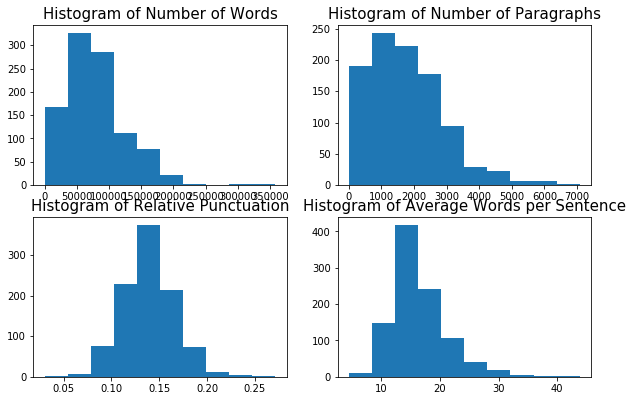

In [142]:
hist_plot(features, ["Number of Words", "Number of Paragraphs", "Relative Punctuation", 
                    "Average Words per Sentence"], rows=3)

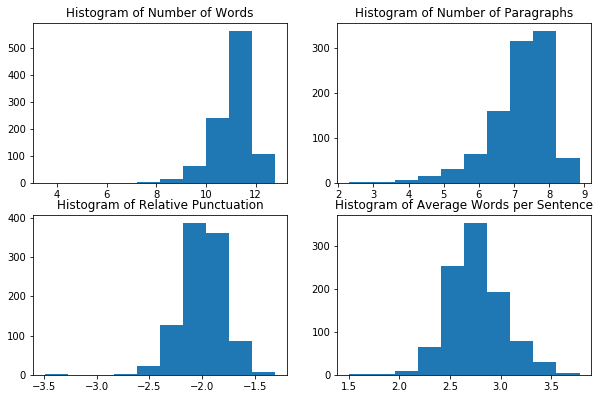

In [239]:
hist_plot(features, ["Number of Words", "Number of Paragraphs", "Relative Punctuation", 
                    "Average Words per Sentence"], rows=3, transform=np.log)

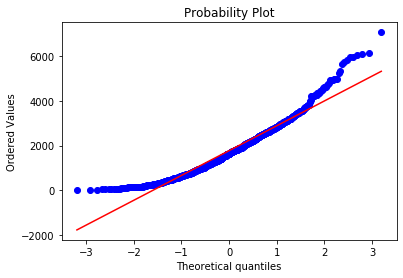

In [205]:
import numpy as np 
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(features["Number of Paragraphs"], dist="norm", plot=pylab)
pylab.show()

### Sentiment
The derived Sentiment Features are in a range of really low values (between 0.0 and 0.2). This is due to the high number of words that don't have sentiment to them. Those words dominate the mean calculation. The standarddeviation is therefore also in a low order of magnitude (~0.01 for all three Features). It seems, that the differnces are not very big, and a rather low predictive Power is assumed. Observing the Histogramms, the Features seem to be normally distributed. If running an Anova, significant results for the Target variable are obtained. This means, that the means of the Sentiment variabes are dependent on the genre. To avoid completely imbalanced samples, the genres with less than 18 cases were comibined in to the genre "other" before running the anova. So the Sentiment Variables will be included in the final model. 

In [69]:
pd.DataFrame(features[["Positive Sentiment", "Negative Sentiment", "Objective Sentiment"]].describe())

,Positive Sentiment,Negative Sentiment,Objective Sentiment
count,994.000000,994.000000,994.000000
mean,0.074587,0.081696,0.843717
std,0.008778,0.011215,0.017867
min,0.041723,0.020833,0.784195
25%,0.069145,0.074372,0.832158
50%,0.074027,0.081475,0.844133
75%,0.079991,0.088712,0.854957
max,0.125200,0.115542,0.930556


In [ ]:
pd.DataFrame(features.describe())

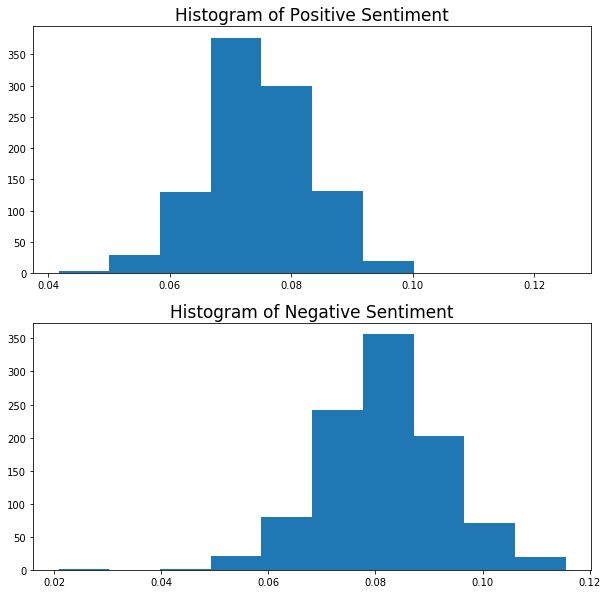

In [178]:
hist_plot(features, ["Positive Sentiment", "Negative Sentiment"], rows=2, cols=1)

In [171]:
target_red = pd.DataFrame(target.copy())
target_red = target_red.replace(to_replace=["Allegories", "Ghost and Horror", "Christmas Stories",
                              "Humorous and Wit and Satire"], value="other")
target_red.guten_genre.value_counts()

Literary                 792
Detective and Mystery    111
Sea and Adventure         36
other                     19
Western Stories           18
Love and Romance          18
Name: guten_genre, dtype: int64

In [172]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
target_int = LE.fit_transform(target_red.guten_genre)
anova = f_classif(features[["Positive Sentiment", "Negative Sentiment", "Objective Sentiment"]], target_int)

In [51]:
anova

(array([16.54550982,  7.56025596, 13.85574188]),
 array([1.03441113e-15, 5.58313690e-07, 4.18956718e-13]))

### Pronouns
The summary statistics for Gender-Orientation confirm some previous Hypothesis. The mean male orientation is higher than the mean female orientation, but at the same time the variance is higher for female orientation. We can see, in the Histogramms, that the Distribution for Male Orientaion seems gaussian, while Female Orientation has a longer tail on the right sight. Some Documents must be highly female oriented, while in other documents females are rare. Male orientation is on a steady high level. The Anova confirms that female orientation has a high predictive power for the genre, while male orintation doesn't. 

In [244]:
features["Male Orientation"] = features["Male Orientation"]/features["Number of Words"]

In [245]:
features["Female Orientation"] = features["Female Orientation"]/features["Number of Words"]

In [158]:
pd.DataFrame(features[["Female Orientation", "Male Orientation"]].describe())

,Female Orientation,Male Orientation
count,994.000000,994.000000
mean,0.021256,0.033063
std,0.012184,0.010700
min,0.000000,0.000000
25%,0.011714,0.025723
50%,0.019563,0.032917
75%,0.029062,0.039723
max,0.067096,0.072407


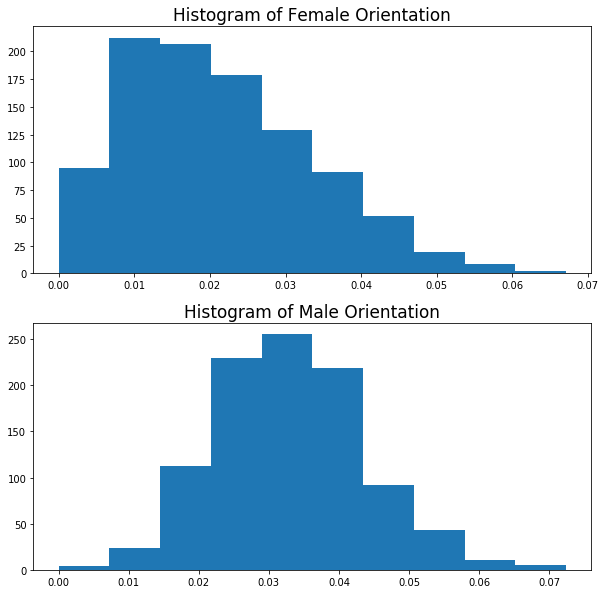

In [159]:
hist_plot(features, ["Female Orientation", "Male Orientation"], rows=2, cols=1)

In [261]:
anova = f_classif(features[["Female Orientation", "Male Orientation"]], target_int)

In [262]:
anova

(array([18.41631007,  2.98306077]), array([1.62597134e-17, 1.11310140e-02]))

In [165]:
features.columns

Index(['Positive Sentiment', 'Negative Sentiment', 'Objective Sentiment',
       'Female Orientation', 'Male Orientation', 'Filename', 'Number of Words',
       'Number of Paragraphs', 'Relative Punctuation',
       'Average Words per Sentence', 'Unnamed: 0', 'Number of Sentences',
       'Number of Dialogs', 'Number of Sentences with Dialogs',
       'Number of Named People', 'Number of Named Places',
       'Number of Named Organizations', 'filenames'],
      dtype='object')

### Named Entities

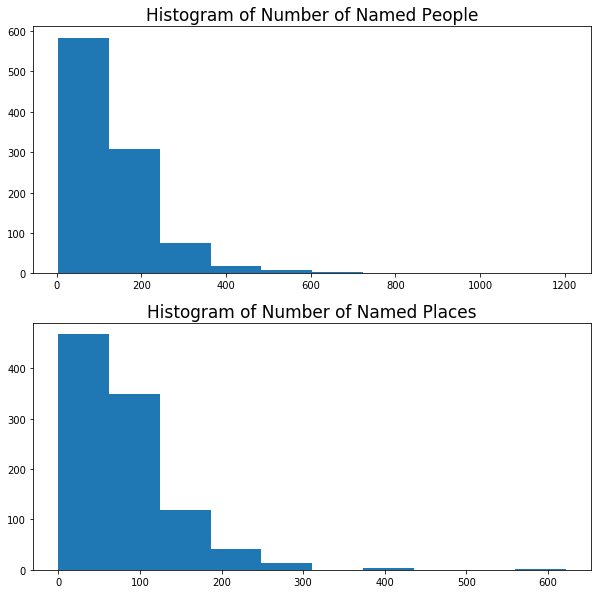

In [168]:
hist_plot(features, ["Number of Named People", "Number of Named Places"], rows=2, cols=1)

In [177]:
anova = f_classif(features[["Number of Named People", "Number of Named Places",
                           "Number of Named Organizations"]], target_int)
anova

(array([2.26459921, 3.03815645, 0.41923445]),
 array([0.04618006, 0.00995158, 0.83554884]))

## Model training

In [179]:
data = features.copy()
data = data.drop("Filename", axis=1)
data = data.drop("filenames", axis=1)
data = data.drop("Unnamed: 0", axis=1)

In [180]:
data

,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Number of Words,Number of Paragraphs,Relative Punctuation,Average Words per Sentence,Number of Sentences,Number of Dialogs,Number of Sentences with Dialogs,Number of Named People,Number of Named Places,Number of Named Organizations
0,0.069583,0.071145,0.859272,0.005163,0.039545,68757,2282,0.175386,12.858986,2283,2476.5,1649,114,71,28
1,0.078844,0.073378,0.847779,0.011589,0.050236,17776,267,0.119768,17.444553,268,337.0,251,21,25,8
2,0.079451,0.083087,0.837462,0.030797,0.037915,151734,3509,0.152899,16.287462,3510,3265.0,2087,145,115,44
3,0.057817,0.066159,0.876024,0.008529,0.040032,89228,3331,0.162158,9.886759,3332,3644.5,2619,173,59,37
4,0.086624,0.091678,0.821698,0.026450,0.030588,17883,471,0.139518,16.760075,472,341.0,264,14,13,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0.079953,0.079557,0.840490,0.018833,0.023576,358420,7080,0.125389,15.768588,7081,203.5,122,274,187,121
990,0.074366,0.078430,0.847204,0.020216,0.031271,103930,2255,0.121745,14.693906,2256,27.0,16,111,55,64
991,0.070811,0.071905,0.857284,0.005611,0.032821,87323,2055,0.124286,15.178689,2056,1913.0,1820,184,142,77
992,0.080267,0.090601,0.829131,0.017686,0.025719,57390,2532,0.170169,9.825372,2533,2211.5,1818,80,36,24


In [181]:
data.corr()

,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Number of Words,Number of Paragraphs,Relative Punctuation,Average Words per Sentence,Number of Sentences,Number of Dialogs,Number of Sentences with Dialogs,Number of Named People,Number of Named Places,Number of Named Organizations
Positive Sentiment,1.000000,0.591202,-0.862383,0.300832,-0.107681,0.102082,0.048573,0.129656,0.098372,0.048573,0.076625,0.064475,0.015831,-0.033707,-0.026604
Negative Sentiment,0.591202,1.000000,-0.918150,0.439280,-0.102255,0.131048,0.051241,0.015577,0.113547,0.051241,0.022076,0.023930,-0.078859,-0.108602,-0.161489
Objective Sentiment,-0.862383,-0.918150,1.000000,-0.423531,0.117088,-0.132410,-0.056028,-0.073476,-0.119602,-0.056028,-0.051502,-0.046696,0.041723,0.084730,0.114437
Female Orientation,0.300832,0.439280,-0.423531,1.000000,-0.113807,0.125278,0.199861,0.018997,-0.202409,0.199861,0.176782,0.162439,-0.117431,-0.182807,-0.150079
Male Orientation,-0.107681,-0.102255,0.117088,-0.113807,1.000000,0.004184,0.053567,-0.072349,-0.189987,0.053567,0.065881,0.049609,-0.113393,-0.066563,-0.035303
Number of Words,0.102082,0.131048,-0.132410,0.125278,0.004184,1.000000,0.784287,0.105374,0.030288,0.784287,0.653995,0.639435,0.600237,0.580225,0.540271
Number of Paragraphs,0.048573,0.051241,-0.056028,0.199861,0.053567,0.784287,1.000000,0.325394,-0.355573,1.000000,0.851260,0.871239,0.383604,0.352164,0.358966
Relative Punctuation,0.129656,0.015577,-0.073476,0.018997,-0.072349,0.105374,0.325394,1.000000,-0.123447,0.325394,0.511565,0.485555,0.096760,-0.013885,-0.029785
Average Words per Sentence,0.098372,0.113547,-0.119602,-0.202409,-0.189987,0.030288,-0.355573,-0.123447,1.000000,-0.355573,-0.345156,-0.364745,0.119194,0.129138,0.011720
Number of Sentences,0.048573,0.051241,-0.056028,0.199861,0.053567,0.784287,1.000000,0.325394,-0.355573,1.000000,0.851260,0.871239,0.383604,0.352164,0.358966


In [182]:
from sklearn.decomposition import PCA
pca = PCA(10)
data = pca.fit_transform(data)

In [183]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data))

In [184]:
#Making train and test-dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                data, target, test_size=0.33)

In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [186]:
lreg = LogisticRegression(max_iter=10000)
nb = GaussianNB()

In [187]:
lreg.fit(x_train, y_train)
nb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [188]:
np.mean(nb.predict(x_test) == y_test)

0.7477203647416414

In [189]:
np.mean(lreg.predict(x_test) == y_test)
#It just predicts Literary all the time so I think the nb is closer to reallity

0.8237082066869301

In [222]:
def sensitivity(X, Y, clf, majority="Literary"):
    X=np.take(X, np.where(Y!="Literary")[0], axis=0)
    Y=np.take(Y, np.where(Y!="Literary")[0], axis=0)
    return(np.mean(clf.predict(X) == Y))

In [224]:
sensitivity(x_test, y_test, nb)

0.08620689655172414